In [1]:
%matplotlib inline
import pandas as pd
import psycopg2
POSTGIS = psycopg2.connect(database='postgis', host='iemdb', user='nobody')
cursor = POSTGIS.cursor()

cursor.execute("""
 with bz as (select wfo, ugc, geom, issue, expire from warnings where phenomena = 'BZ' 
 and significance = 'W'), svto as (SELECT phenomena, wfo, geom, issue, expire from sbw where 
 phenomena in ('TO','SV')  and significance = 'W' and issue > '2005-10-01' and status = 
 'NEW') SELECT bz.ugc, bz.issue, bz.expire, svto.issue, svto.expire, svto.phenomena from bz, svto WHERE 
 svto.wfo = bz.wfo and ST_Intersects(bz.geom, svto.geom) and svto.expire > bz.issue and 
 svto.issue < bz.expire ORDER by bz.issue ASC
""")
rows = []
for row in cursor:
    rows.append( dict(ugc=row[0], bzissue=row[1], bzexpire=row[2], wissue=row[3], wexpire=row[4],
                      wtype=row[5]))
    
df = pd.DataFrame(rows)


ERROR: An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



ProgrammingError: column "geom" does not exist
LINE 2:  with bz as (select wfo, ugc, geom, issue, expire from warni...
                                      ^


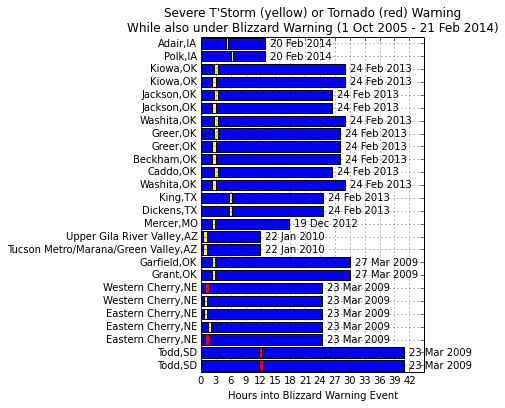

In [33]:
POSTGIS = psycopg2.connect(database='postgis', host='iemdb', user='nobody')
cursor = POSTGIS.cursor()
import matplotlib.pyplot as plt

(fig, ax) = plt.subplots(1,1, figsize=(4,6))
ylabels = []
yticks = []
j = 0
colors = {'SV':'yellow', 'TO':'red'}
for i, row in enumerate(df.iterrows()):
    sz = (df['bzexpire'][i] - df['bzissue'][i]).days * 86400. + (df['bzexpire'][i] - df['bzissue'][i]).seconds
    offset2 = (df['wissue'][i] - df['bzissue'][i]).days * 86400. + (df['wissue'][i] - df['bzissue'][i]).seconds
    if offset2 < 0:
        continue
    ax.barh(j-0.4, sz, zorder=1)
    ax.text(sz+3600, j, "%s" % (df['wexpire'][i].strftime("%-d %b %Y"),), va='center')
    cursor.execute("""SELECT name ||','||state from ugcs where ugc = %s LIMIT 1""", (df['ugc'][i],))
    name = cursor.fetchone()[0]
    ylabels.append(name)
    sz = (df['wexpire'][i] - df['wissue'][i]).days * 86400. + (df['wexpire'][i] - df['wissue'][i]).seconds
    #print row, sz, offset2
    ax.barh(j-0.4, sz, left=offset2, facecolor=colors[df['wtype'][i]], zorder=2)
    yticks.append(j)
    j += 1
    
b = ax.set_yticklabels(ylabels)
a = ax.set_yticks(yticks)
ax.set_ylim(-0.5,len(ylabels)-0.5)
ax.set_xticks( range(0,10800*15+1,10800))
ax.set_xticklabels( range(0,43,3) )
ax.grid(True)
ax.set_xlabel("Hours into Blizzard Warning Event")
ax.set_title("Severe T'Storm (yellow) or Tornado (red) Warning\nWhile also under Blizzard Warning (1 Oct 2005 - 21 Feb 2014)")